Graphs to aid in visualization of the data

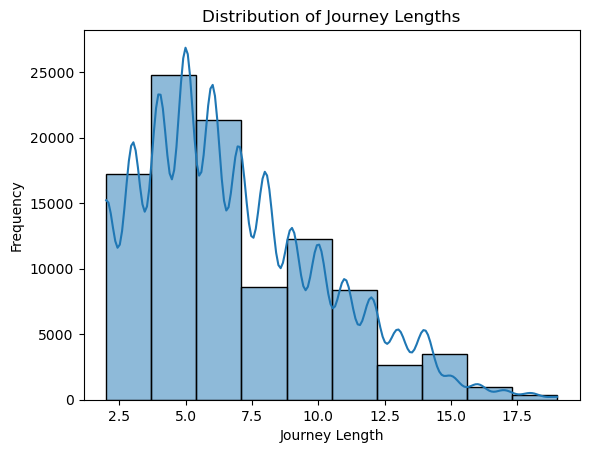

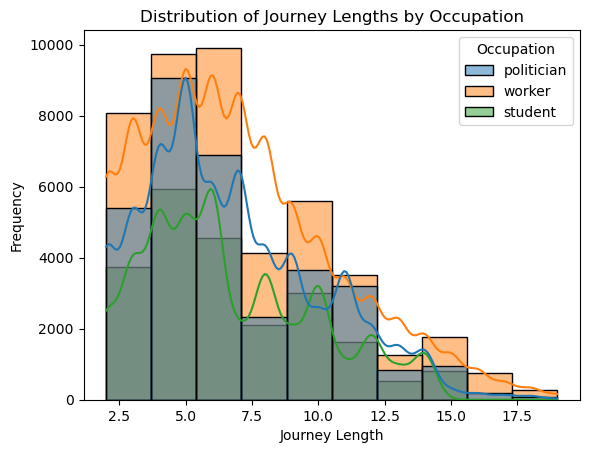

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.read_csv('mrtJourneys.csv', na_values='null')
data['journey_length'] = data.iloc[:, 1:-2].apply(lambda x: x.notnull().sum(), axis=1)
sns.histplot(data=data, x='journey_length', kde=True, bins=10)
plt.xlabel('Journey Length')
plt.ylabel('Frequency')
plt.title('Distribution of Journey Lengths')
plt.show()
sns.histplot(data=data, x='journey_length', hue='Occupation', kde=True, bins=10)
plt.xlabel('Journey Length')
plt.ylabel('Frequency')
plt.title('Distribution of Journey Lengths by Occupation')
plt.show()

Number of people at a station by occupation

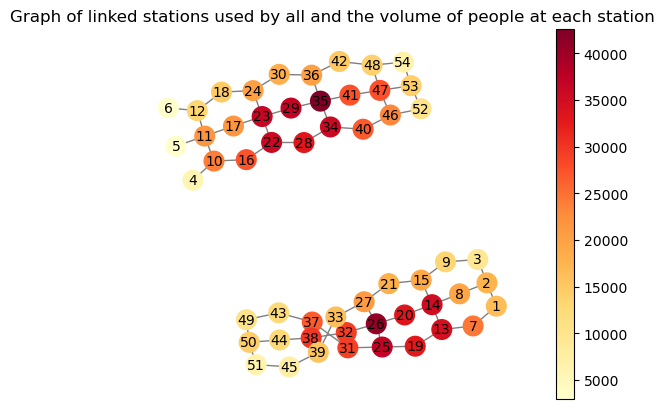

In [39]:
#train_ratio = 0.8
#test_ratio = 1 - train_ratio
#politician_train, politician_test = train_test_split(politician, train_size=train_ratio, random_state=42)
#worker_train, worker_test = train_test_split(worker, train_size=train_ratio, random_state=42)
#students_train, students_test = train_test_split(students, train_size=train_ratio, random_state=42)
#train_data = politician_train + worker_train + students_train
#test_data = politician_test + worker_test + students_test


import sklearn
import networkx as nx
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
#mrt_line = {mrt line : [connect mrt line]}
#mrt_crowd = {mrt line : [Num of Passenger at time interval of 2 mins]}
worker = []
politician = []
students = []
all = []
with open('mrtJourneys.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) # Skip header row
    for row in reader:
        occupation = row[-1]
        if occupation == 'politician':
            politician.append(row)
        elif occupation == 'worker':
            worker.append(row)
        elif occupation == 'student':
            students.append(row)
        all.append(row)


def graph(data):
    mrt_time = dict()
    graph_mrt_line = dict()
    edge = np.zeros((54, 54))
    exit = dict()
    for row in data:
        try:
            start_null = row.index('null')
        except:
            start_null = len(row) - 2
        if start_null == 2:
            if int(row[1]) not in mrt_time:
                mrt_time[int(row[1])]=[0 for i in range(1, len(row) - 2)]
            mrt_time[int(row[1])][0] += 1   
        for index in range(2, start_null):
            prev = int(row[index-1])
            current = int(row[index])
            if prev not in graph_mrt_line:
                graph_mrt_line[prev] = []
            if current not in graph_mrt_line:
                graph_mrt_line[current] =[]
            prev_list = graph_mrt_line[prev]
            current_list = graph_mrt_line[current]
            if prev not in current_list:
                current_list.append(prev)
            if current not in prev_list:
                prev_list.append(current)
            if prev not in mrt_time:
                mrt_time[prev]=[0 for i in range(1, len(row) - 2)]
            if current not in mrt_time:
                mrt_time[current]=[0 for i in range(1, len(row) - 2)]
            mrt_time[prev][index - 2]+=1
            mrt_time[current][index -1]+=1
            edge[prev-1][current-1] += 1
            if index + 1 == start_null:
                exit[current] = exit.get(current, 0) + 1
    return graph_mrt_line, mrt_time, edge, exit
mrt_line_all, mrt_crowd_all, edge_all, exit_all = graph(all)
mrt_line_worker, mrt_crowd_worker, edge_worker, exit_worker = graph(worker)
mrt_line_politician, mrt_crowd_politician, edge_politician, exit_politician = graph(politician)
mrt_line_students, mrt_crowd_students, edge_students, exit_students = graph(students)

# Add nodes and edges to the graph
def draw_graph(mrt_line_all,mrt_crowd,occupation, seed, exit, val):
    G = nx.Graph()
    node_features = {}
    node_colors = []
    for station, connected_stations in mrt_line_all.items():
        G.add_node(station)
        node_features[station] = {'crowd_density' : sum(mrt_crowd[station]), 'exit': exit.get(station,0)}
        for connected_station in connected_stations:
            G.add_edge(station, connected_station)
    pos = nx.spring_layout(G, seed=seed)
    nx.set_node_attributes(G, node_features)
    
    for node in G.nodes():
        node_colors.append(node_features[node][val])
    # Create heat map of node colors based on crowd density
    cmap = plt.cm.get_cmap('YlOrRd')
    df = pd.DataFrame(index=G.nodes(), columns=G.nodes())
    for row, data in nx.shortest_path_length(G):
        for col, dist in data.items():
            df.loc[row,col] = dist
    df = df.fillna(df.max().max())
    # Draw the weighted graph
    pos = nx.kamada_kawai_layout(G, dist=df.to_dict())
    node_color_map = nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, cmap=cmap, node_size=200)
    # Draw edges
    nx.draw_networkx_edges(G, pos=pos, edge_color='gray')
    # Add labels
    nx.draw_networkx_labels(G, pos=pos, font_size=10, font_family='sans-serif')
    # Add colorbar
    plt.colorbar(node_color_map)
    plt.title('Graph of linked stations used by ' + occupation + ' and the volume of people at each station' if val == 'crowd_density' else "Volume of people exit at each station" + "("+occupation+")")
    plt.axis('off')
    plt.show()

    ##nx.draw(G, pos= pos, with_labels=True, node_color='cyan', font_weight='bold')
    #plt.title('Graph of linked station used by ' + occupation)
    #plt.show()
    return G
graph_all = draw_graph(mrt_line_all, mrt_crowd_all, "all" , 8, exit_all, 'crowd_density')




Based on the density plot, it is evident that stations 35 and 26 have the highest density of commuters travelling between 0602hrs to 0638hrs, with over 40,000 commuters passing through. Given the high frequency of commuters, it is imperative to prioritize these stations and implement safety measures such as deploying marshals to prevent accidents and ensure smooth crowd management. We should provide additional staffing at these stations during morning peak hours to ensure that passengers can move through the station quickly and safely, thus improving overall satisfaction.

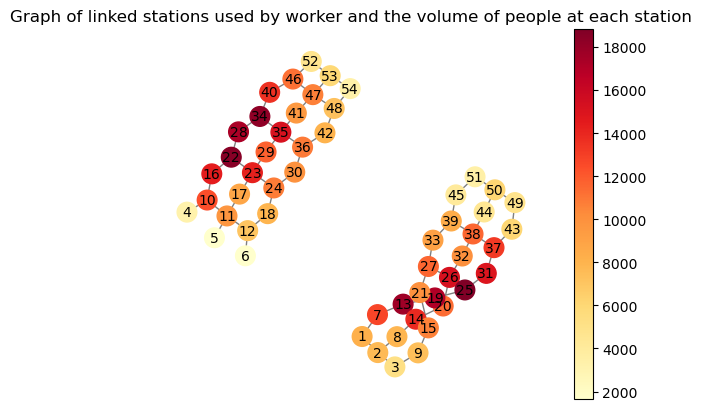

In [40]:
graph_worker = draw_graph(mrt_line_worker,mrt_crowd_worker, "worker", 18, exit_worker, 'crowd_density')


According to the density plot, the commuter density is the highest, with over 17000 workers, at stations 13, 19, 22, 25, 28, and 34 between 0602hrs and 0638hrs, indicating that these stations are likely located in popular business districts. With this information on the commuting patterns of workers, we can also estimate the volume of people during the peak evening rush hour, which typically occurs between 1730hrs and 1830hrs. By deploying marshals to stations 13, 19, 22, 25, 28, and 34 during this time, we can effectively control the crowds.

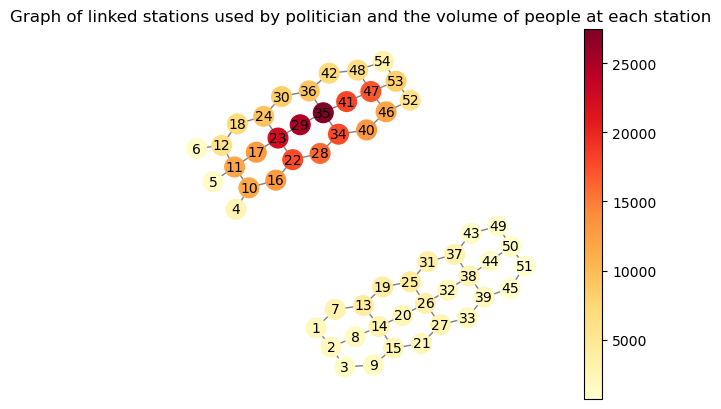

In [41]:
graph_politician = draw_graph(mrt_line_politician, mrt_crowd_politician, "politician",18, exit_politician, 'crowd_density')


Based on the density plot, stations 22, 23, 28, 29, 34, 35, 41, and 47 appear to be the popular routes among politicians. Therefore, security measures at these stations should be the tightest as compared to other stations. Specifically, station 35 requires the most stringent security measures, as over 25,000 politicians pass through it between 0602hrs and 0638hrs. As a result, the frequency of security patrols around these stations should be increased significantly.

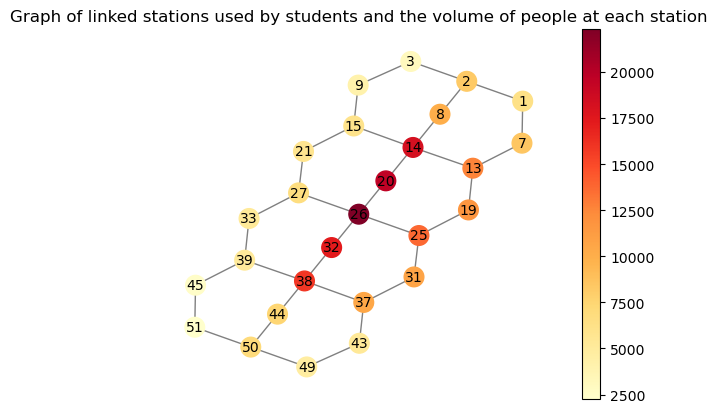

In [42]:
graph_students = draw_graph(mrt_line_students,mrt_crowd_students, "students",8, exit_students, 'crowd_density')

Mrt Exit

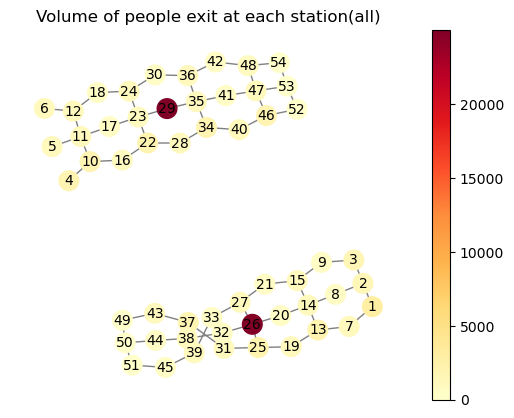

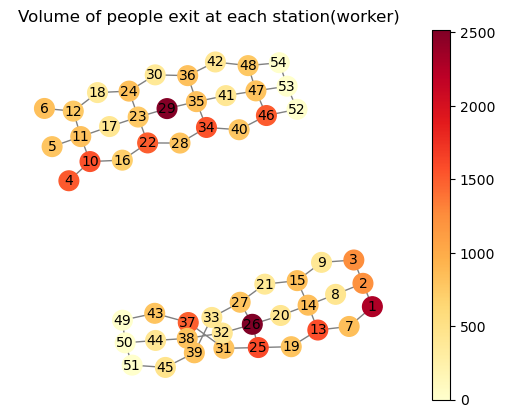

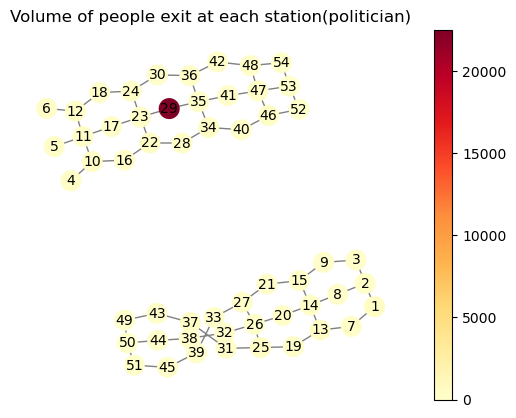

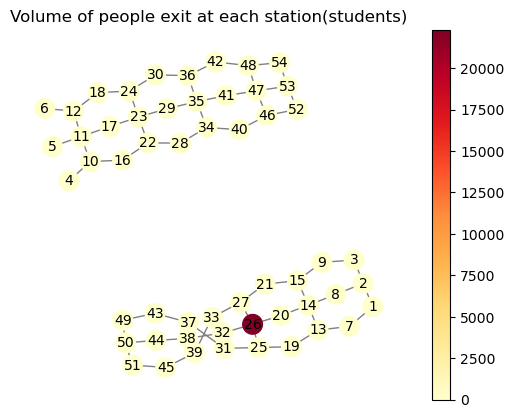

In [43]:
graph_exit_all = draw_graph(mrt_line_all, mrt_crowd_all, "all" , 8, exit_all, 'exit')
graph_exit_worker = draw_graph(mrt_line_all, mrt_crowd_all, "worker" , 8, exit_worker, 'exit')
graph_exit_politician = draw_graph(mrt_line_all, mrt_crowd_all, "politician" , 8, exit_politician, 'exit')
graph_exit_studetns = draw_graph(mrt_line_all, mrt_crowd_all, "students" , 8, exit_students, 'exit')



Based on the above plots, we can anticipate the formation of crowds at stations 26 and 29 as commuters exit these stations. Therefore, it is advisable to install additional gantries at these stations to facilitate easy exits for commuters. Additionally, the maintenance of these gantries must be prioritized since they will be subjected to higher usage than other stations. Any faults or breakdowns of these gantries will lead to significant disruptions in commuter traffic and potentially result in long queues. This, in turn, will lead to a decline in the quality of commuting experience for commuters. 

In an event when a train break down at a particular station we need to provide shuttle service at station where the next station is not possible to reach by the train.

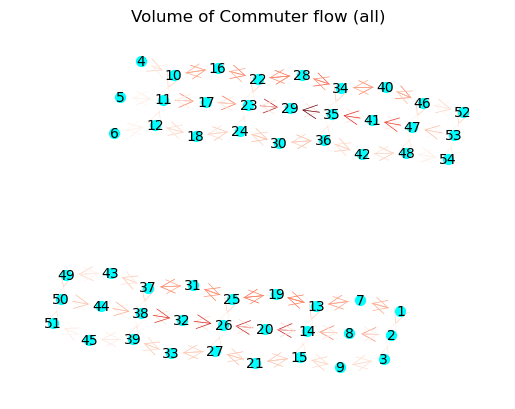

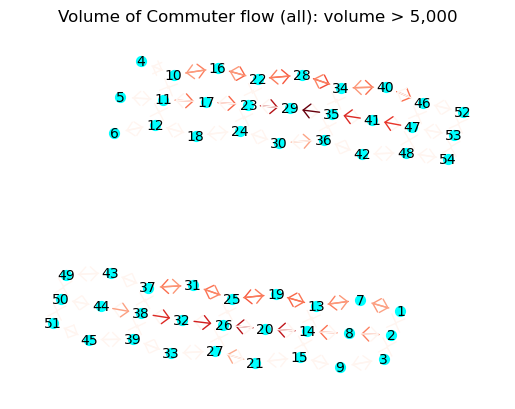

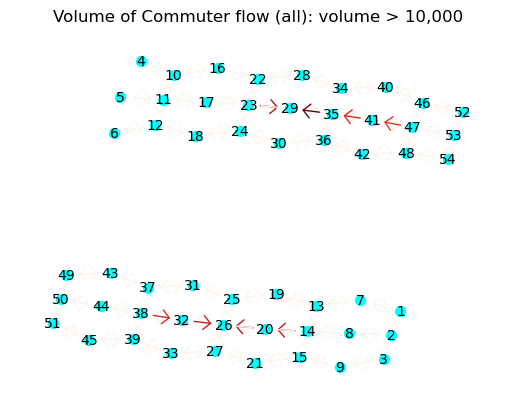

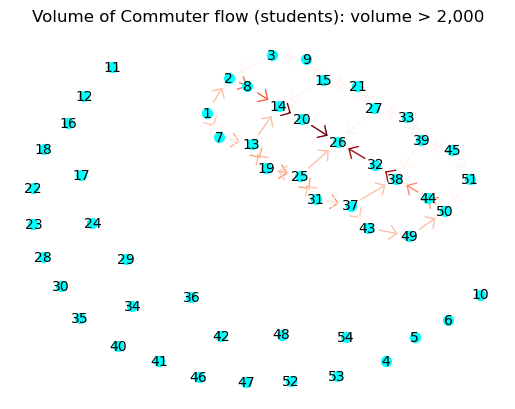

In [44]:

def graph_weight(edge_all, *arg):
    G = nx.from_numpy_array(edge_all, create_using=nx.DiGraph) #https://stackoverflow.com/questions/14283341/how-to-increase-node-spacing-for-networkx-spring-lay
    mapping = {old_label: old_label + 1 for old_label in G.nodes()}
    G = nx.relabel_nodes(G, mapping)
    df = pd.DataFrame(index=G.nodes(), columns=G.nodes())
    for row, data in nx.shortest_path_length(G):
        for col, dist in data.items():
            df.loc[row,col] = dist

    df = df.fillna(df.max().max())
    # Draw the weighted graph
    pos = nx.kamada_kawai_layout(G, dist=df.to_dict())
    edge_colors = [G[u][v]['weight'] for u,v in G.edges()]
    if arg:
        weight_threshold = int(arg[0])
        edge_colors = []
        for u, v, d in G.edges(data=True):
            if d['weight'] < weight_threshold:
                edge_colors.append(0)
                continue
            edge_colors.append(d['weight'])
            



        # Create custom colormap with upper half of Reds colormap
        # Draw graph
        nx.draw_networkx_nodes(G, pos=pos, node_color='cyan', node_size=50)
        nx.draw_networkx_labels(G, pos=pos, font_size=10, font_family='sans-serif')
        edges = nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, edge_cmap= plt.cm.get_cmap('Reds'), arrowstyle='->,head_width=0.5,head_length=0.5')
        plt.axis('off')
        plt.title('Volume of Commuter flow'+' '+ arg[1]+ ': '+ 'volume > '+ arg[2])
        plt.show()
        return G
    nx.draw_networkx_nodes(G, pos=pos, node_color='cyan', node_size=50)
    nx.draw_networkx_labels(G, pos=pos, font_size=10, font_family='sans-serif')
    nx.draw_networkx_edges(G, pos=pos, edge_color=edge_colors, edge_cmap=plt.cm.get_cmap('Reds'), arrowstyle='->,head_width=0.5,head_length=1', width=0.5)
    plt.axis('off')
    plt.title('Volume of Commuter flow (all)')
    plt.show()
    return G
#normalise the number of commuter travelling from station to station
edge_all = edge_all #/ np.amax(edge_all)
graph_all_weight = graph_weight(edge_all)
graph_weight(edge_all, '5000', '(all)','5,000')
graph_weight(edge_all, '10000', '(all)', '10,000')
graph_weight(edge_students, '2000', '(students)', '2,000')


Getting the stations in each cluster

In [45]:
G = nx.Graph()

# Adding the nodes and edges to the graph
for station, connected_stations in mrt_line_all.items():
    G.add_node(station)
    for connected_station in connected_stations:
        G.add_edge(station, connected_station)
pos = nx.spring_layout(G, seed=8)


# Get the connected components of the graph
connected_components = list(nx.connected_components(G))
cluster1 = connected_components[0]
cluster2 = connected_components[1]



Identifying the stations with high degree centrality and betweenness centrality

In [80]:
import numpy as np
import pandas as pd
import networkx as nx
from itertools import combinations


df = pd.read_csv('mrtJourneys.csv')

# Creating a MRT graph (Edge = Commuter Frequency Graph)
G = nx.Graph()
for i in range(len(df)):
    row = df.iloc[i]
    path = row[1:-2]
    for j in range(len(path)-1):
        if pd.notna(path[j]) and pd.notna(path[j+1]):
            edge = (path[j], path[j+1])
            if G.has_edge(*edge):
                G[edge[0]][edge[1]]['weight'] += 1
            else:
                G.add_edge(*edge, weight=1)

# Loading the station data with the dictionary with the key as the station name and the value as the list of the number of commuters
station_data = mrt_crowd_all

# Calculating average commuter traffic for each station
station_traffic = {}
for station, data in station_data.items():
    total_traffic = sum(data)
    avg_traffic = total_traffic / len(data)
    station_traffic[station] = avg_traffic

# Finding the different subgraphs (different "clusters") of the graph
subgraphs = list(nx.connected_components(G))

# Loop over each subgraph ("cluster") to calculate metrics
for i, subgraph in enumerate(subgraphs):
    print(f"Cluster {i+1}:")
    # Create a subgraph for the current cluster
    subgraph_G = G.subgraph(subgraph)
    # Calculate degree centrality for the current cluster
    degree_centrality = nx.degree_centrality(subgraph_G)
    # Print the top few stations by degree centrality for the current cluster
    sorted_degree_stations = sorted(degree_centrality, key=degree_centrality.get, reverse=True)
    print("Top 10 stations by degree centrality:")
    for station in sorted_degree_stations[:10]:
        print(station)
    # Calculate the longest path betweenness centrality for each station in the current cluster
    # since each edge represents the number of commuters, we can use the edge weight as the distance
    station_centrality = {}
    for station in station_data.keys():
        if station in subgraph:
            s = station
            node_centrality = 0.0
            paths = nx.single_source_dijkstra_path(subgraph_G, s, weight='weight')
            path_lengths = nx.single_source_dijkstra_path_length(subgraph_G, s, weight='weight')
            nodes_sorted_by_distance = [v for v, _ in sorted(path_lengths.items(), key=lambda x: -x[1])]
            dependency = {v: 0.0 for v in subgraph_G.nodes()}
            for v in nodes_sorted_by_distance:
                if v == s:
                    continue
                for w in subgraph_G.neighbors(v):
                    if path_lengths[w] == path_lengths[v] - subgraph_G[v][w]['weight']:
                        dependency[w] += (1.0 + dependency[v]) / len(list(subgraph_G.neighbors(v)))
                if v != s:
                    node_centrality += dependency[v]
            station_centrality[station] = node_centrality
    # Now, we will sort stations by longest path betweenness centrality
    sorted_stations = sorted(station_centrality, key=station_centrality.get, reverse=True)
    # Print the top few stations by longest path betweenness centrality for the current cluster
    print("Top 10 stations by longest path betweenness centrality:")
    for station in sorted_stations[:10]:
        print(station)
    

Cluster 1:
Top 10 stations by degree centrality:
38.0
26.0
14.0
37
50.0
13.0
2.0
39
25.0
27.0
Top 10 stations by longest path betweenness centrality:
1
49
43
7
44
8
3
51
31
45
Cluster 2:
Top 10 stations by degree centrality:
35.0
47.0
11
23.0
46
34.0
36
24.0
12.0
48.0
Top 10 stations by longest path betweenness centrality:
52
4
5
54
6
28
40
53
29
41


The code output contains valuable information about the MRT network's crucial stations based on two centrality measures: degree centrality and longest path betweenness centrality. Degree centrality assesses each station's connections (edges), while longest path betweenness centrality evaluates a station's significance in maintaining traffic flow between other stations.

The top 10 stations by degree centrality and longest path betweenness centrality for each of the two clusters are listed above. This information can be employed to enhance the MRT travel experience in various ways.

Stations that have a high degree centrality can be prioritized for improvements to connectivity, such as adding more trains or increasing the frequency of trains to improve the waiting times, improving overall travel experience for commuters.

However, even though a station may have high degree centrality, they may not be used as heavily as other stations. Hence, one will need to consider the betweenness centrality as well to truly best use the information to improve the MRT travel experience as well as to make use of limited resources

Stations that have the highest longest path betweenness centrality are critical for maintaining traffic flow between other stations in the network. One can take measures after obtaining this information to optimize traffic flow, such as improving signalling or train scheduling to reduce congestion and delays.


These stations and the path leading to and from them should also be regularly checked and maintained, as if there were to be disruptions that occur at these stations, it would lead to major disruptions due to them lying on the most frequently used routes in the network


Stations that have both high degree centrality and longest path betweenness centrality can be used to prioritize station upgrades and improvements. This includes upgrades to facilities such as toilets, escalators and lifts to improve the overall travel experience for commuters.




Finding the top 10 edges by weighted betweenness centrality

Top 10 edges by edge traffic betweenness centrality:[(27, 26), (44, 50), (11, 12), (36, 35), (14, 15), (50, 51), (51, 45), (38, 44), (47, 48), (47, 53)]


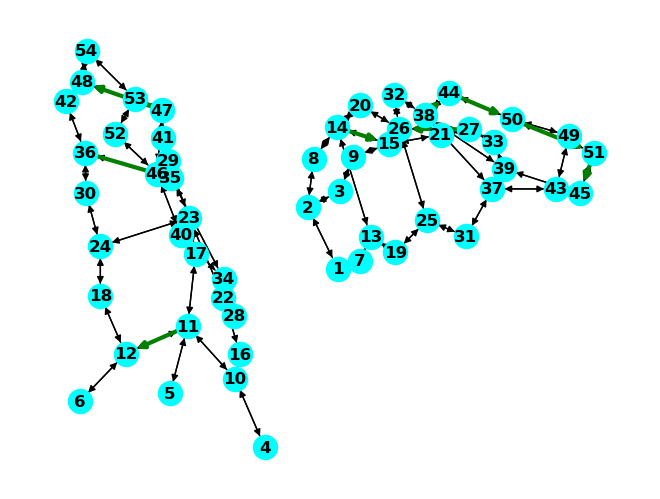

In [47]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

df = pd.read_csv('mrtJourneys.csv')
adj_matrix = defaultdict(lambda: defaultdict(int))
for _, row in df.iterrows():
    for i in range(1, len(row) - 3):
        if not pd.isna(row[i]) and not pd.isna(row[i + 1]):
            adj_matrix[int(row[i])][int(row[i + 1])] += 1

# Creating a graph from the adjacency matrix
G = nx.DiGraph()
for station1, connections in adj_matrix.items():
    for station2, weight in connections.items():
        G.add_edge(station1, station2, weight=weight)

# Calculating the edge traffic betweenness centrality of each edge
etbc, num_shortest_paths = {}, {}
for source in G.nodes():
    for target in G.nodes():
        if source != target:
            try:
                shortest_paths = nx.dijkstra_path(G, source, target, weight='weight')
                # print(shortest_paths)
                num_shortest_paths[(source, target)] = 1
                count = len(shortest_paths) - 1
                for i in range(count):
                    edge = (shortest_paths[i], shortest_paths[i + 1])
                    if edge not in etbc:
                        temp = adj_matrix[edge[0]][edge[1]]
                        etbc[edge] = 1 / temp
                    else:
                        temp = adj_matrix[edge[0]][edge[1]]
                        etbc[edge] += 1 / temp
            except nx.NetworkXNoPath:
                pass
total_shortest_paths = sum(num_shortest_paths.values())
etbc = {edge: centrality / total_shortest_paths for edge, centrality in etbc.items()}
# print(total_shortest_paths)
# print(etbc)

# Obtaining the top edges by edge traffic betweenness centrality

sorted_etbc = {k: v for k, v in sorted(etbc.items(), key=lambda item: item[1], reverse=True)}
top_10 = list(sorted_etbc.keys())[:10]
print("Top 10 edges by edge traffic betweenness centrality:" + str(top_10))

# Drawing the graph
pos = nx.spring_layout(G, k=0.2, iterations=20, seed=18)
nx.draw(G, pos=pos, with_labels=True, node_color='cyan', font_weight='bold')

# Highlighting the top 10 edges with the highest edge traffic betweenness centrality
for edge in top_10:
    nx.draw_networkx_edges(G, pos, edgelist=[edge], edge_color='green', width=3)

# Show the plot
plt.axis('off')
plt.show()


Here we can see the top 10 edges based on weighted betweenness centrality. This information represents the top 10 edges that are most frequently used by commuters, obtained by taking into account the freqeuency of commuters who use each edge. These edges indicate that they are crucial when it comes to maintaining connectivity across the network and for ensuring that commuters can travel efficiently between stations. The MRT travelling experience can be ideally be improved by focusing on these edges.

Since these edges are likely to be the most congested in the network during peak hours. With this information, we can take measures to aim to alleviate the potential high traffic along these edges. This can be done by using trains with high capacity during these hours (trains with seats that can be folded up to increase capacity) or by increasing the frequency of trains along these routes during these hours.

Also, with this information, we can expect an increase in demand for train services going in the opposite direction at the end of the day. Hence, we can increase the train frequency for these routes at the end of the day to match the anticipated increase in demand.

Stations that have both a high degree centrality and the longest path betweenness centrality can be used to prioritize station upgrades and improvements. This includes upgrades to facilities such as toilets, escalators and lifts to improve the overall travel experience for commuters.


Statistics used to calculate the most popular routes for each cluster


In [48]:
import pandas as pd
import numpy as np


df = pd.read_csv('mrtJourneys.csv')

# Excluding the columns that are not needed
station_cols = df.columns[1:-2]

# Count only the non-null stations
station_counts = df[station_cols].count(axis=1)

# Finding the average number of stations commuters travel
avg_num_stations = station_counts.mean()

print(f"Average number of stations visited per commuter: {avg_num_stations:.2f}")


# Getting the most popular entry station for both clusters
pop_entry_cluster1 = df[df['0602hr'].isin(cluster1)]['0602hr'].mode().iloc[0]
pop_entry_cluster2 = df[df['0602hr'].isin(cluster2)]['0602hr'].mode().iloc[0]
pop_entry_total = df['0602hr'].mode().iloc[0]

print("Most popular entry station for cluster 1:", pop_entry_cluster1)
print("Most popular entry station for cluster 2:", pop_entry_cluster2)
print("Most popular entry station for all commuters:", pop_entry_total)

# Getting the average number of stations that commuters travel within their own cluster
avg_stations_cluster1 = df[df['0602hr'].isin(cluster1)][station_cols].notna().sum(axis=1).mean()
avg_stations_cluster2 = df[df['0602hr'].isin(cluster2)][station_cols].notna().sum(axis=1).mean()

print("Average number of stations that commuters travel within their own cluster for cluster 1:", avg_stations_cluster1)
print("Average number of stations that commuters travel within their own cluster for cluster 2:", avg_stations_cluster2)



Average number of stations visited per commuter: 6.81
Most popular entry station for cluster 1: 1
Most popular entry station for cluster 2: 4
Most popular entry station for all commuters: 1
Average number of stations that commuters travel within their own cluster for cluster 1: 6.8381
Average number of stations that commuters travel within their own cluster for cluster 2: 6.7849


Station of commuters by occupation

In [49]:
import pandas as pd
import numpy as np


df = pd.read_csv('mrtJourneys.csv')


# Excluding the columns that are not needed
station_cols = df.columns[1:-2]

# Group by Occupation
grouped_by_occupation = df.groupby('Occupation')

# Using previously obtained stations that constitute cluster 1 and cluster 2
cluster1_stations = cluster1  
cluster2_stations = cluster2 

# Calculate the average number of stations visited per commuter by occupation
average_stations_by_occupation = df.groupby('Occupation').apply(lambda x: x.iloc[:, 1:-2].count(axis=1).mean())

# Get the most popular entry station for each occupation for each cluster
pop_entry_cluster1_by_occupation = df[df['0602hr'].isin(cluster1_stations)].groupby('Occupation')['0602hr'].apply(lambda x: x.mode().iloc[0])
pop_entry_cluster2_by_occupation = df[df['0602hr'].isin(cluster2_stations)].groupby('Occupation')['0602hr'].apply(lambda x: x.mode().iloc[0])


print("Average number of stations visited per commuter by occupation:")
print(average_stations_by_occupation)
print("\nMost popular entry station for each occupation in cluster 1:")
print(pop_entry_cluster1_by_occupation)
print("\nMost popular entry station for each occupation in cluster 2:")
print(pop_entry_cluster2_by_occupation)


Average number of stations visited per commuter by occupation:
Occupation
politician    6.693239
student       6.623734
worker        6.989973
dtype: float64

Most popular entry station for each occupation in cluster 1:
Occupation
politician    1
student       1
worker        1
Name: 0602hr, dtype: int64

Most popular entry station for each occupation in cluster 2:
Occupation
politician     4
worker        34
Name: 0602hr, dtype: int64


Finding the most popular route used by commuters, Directed Graph


In [82]:

def draw_graph_with_path(G, route, title, pos, path_color):
    pos = nx.kamada_kawai_layout(G)

    # Draw non-route edges
    non_path_edges = [e for e in G.edges() if e not in [(route[i], route[i + 1]) for i in range(len(route) - 1)]]
    nx.draw_networkx_edges(G, pos, edgelist=non_path_edges, edge_color='black', width=1.5, arrowsize=10, arrowstyle='-|>')
    nx.draw(G, pos= pos, with_labels=True, node_color='cyan')

    # Draw the route edges
    path_edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=path_color, width=3, arrowsize=10, arrowstyle='-|>')

    # Draw the nodes
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

    #Draw the route nodes
    nx.draw_networkx_nodes(G, pos, nodelist=route, node_color=path_color, node_size=500)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def draw_path(G, route, title, pos, path_color):
    pos = nx.kamada_kawai_layout(G)

    # Draw the path edges
    path_edges = [(route[i], route[i + 1]) for i in range(len(route) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color=path_color, width=3, arrowsize=10, arrowstyle='-|>')

    # Draw the nodes
    nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

    #Draw the path nodes
    nx.draw_networkx_nodes(G, pos, nodelist=route, node_color=path_color, node_size=500)
    plt.axis('off')
    plt.title(title)
    plt.show()
    
def find_filtered_route(filename, occupation, cluster, start):
    flag = occupation == 'politician' or occupation == 'worker'

    # Create an empty directed graph
    G = nx.DiGraph()

    # Calculate the edge weights and add them to the graph
    if flag:
        for _, row in df.iterrows():
            for i in range(1, len(row) - 3):
                if row[i] in cluster:
                    if row[-1] == occupation:
                        if not pd.isna(row[i]) and not pd.isna(row[i + 1]):
                            start_station = int(row[i])
                            end_station = int(row[i + 1])
                            weight = sum(row[1:-3].fillna(0))
                            G.add_edge(start_station, end_station, weight=weight)
    # Students only travel in one cluster, filter by cluster is irrelevant
    elif occupation == "student":
          for _, row in df.iterrows():
            for i in range(1, len(row) - 3):
                if row[-1] == occupation:
                    if not pd.isna(row[i]) and not pd.isna(row[i + 1]):
                        start_station = int(row[i])
                        end_station = int(row[i + 1])
                        weight = sum(row[1:-3].fillna(0))
                        G.add_edge(start_station, end_station, weight=weight)
    else:
        for _, row in df.iterrows():
            for i in range(1, len(row) - 3):
                if row[i] in cluster:
                    if not pd.isna(row[i]) and not pd.isna(row[i + 1]):
                        start_station = int(row[i])
                        end_station = int(row[i + 1])
                        weight = sum(row[1:-3].fillna(0))
                        G.add_edge(start_station, end_station, weight=weight)

    def get_top_six_edges(graph, start_node):
        # Check if the start_node is a valid node in the graph
        if start_node not in graph.nodes():
            raise ValueError(f"Node {start_node} is not a valid node in the graph")
        
        # Get all the outgoing edges from the start node
        edges = graph.out_edges(start_node, data=True)
        
        # Sort the edges by weight in descending order
        edges = sorted(edges, key=lambda x: x[2]['weight'], reverse=True)
        
        # Return the top six edges
        return edges[:6]

    def find_route(graph):
        # Initialize the heaviest route to be empty
        heaviest_route = []
        
        # Iterate through all the nodes in the graph
        for node in graph.nodes():
            # Get the six heaviest edges starting from this node
            top_six_edges = get_top_six_edges(graph, node)
            
            # Iterate through each of the top six edges and find the heaviest route
            for edge in top_six_edges:
                # Initialize the current route to be the starting edge
                current_route = [edge]
                current_weight = edge[2]['weight']
                visited_nodes = set([edge[0], edge[1]])
                
                # Follow the edge to the next node and continue until we have a route of length 6
                for i in range(5):
                    next_node = current_route[-1][1]
                    next_edges = graph.out_edges(next_node, data=True)
                    
                    # Filter out the edges that are already in the current route
                    next_edges = [e for e in next_edges if e not in current_route]
                    
                    # Filter out edges that lead to visited nodes, which would create a cycle
                    next_edges = [e for e in next_edges if e[1] not in visited_nodes]
                    
                    # If there are no more edges to follow, break out of the loop
                    if len(next_edges) == 0:
                        break
                    
                    # Get the heaviest edge and add it to the current route
                    heaviest_edge = max(next_edges, key=lambda x: x[2]['weight'])
                    current_route.append(heaviest_edge)
                    current_weight += heaviest_edge[2]['weight']
                    visited_nodes.add(heaviest_edge[1])
                
                # Update the heaviest route if the current route is heavier and does not contain cycles
                if current_weight > sum([e[2]['weight'] for e in heaviest_route]) and len(current_route) == 6:
                    heaviest_route = current_route
        
        
        
        node_list = []
        for edge in heaviest_route:
            if edge[0] not in node_list:
                node_list.append(edge[0])
            if edge[1] not in node_list:
                node_list.append(edge[1])
        return node_list

    # Find the most used connected route
    route = find_route(G)
    return G, route

Popular route used by all commuters for Cluster 1

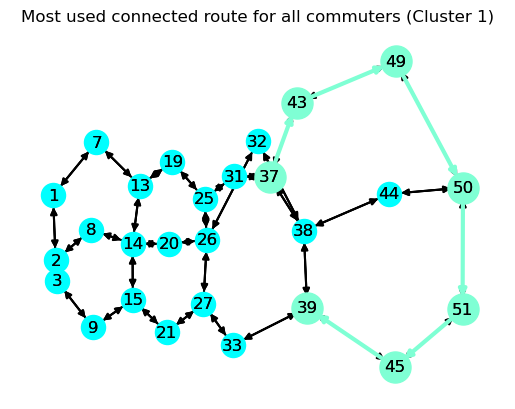

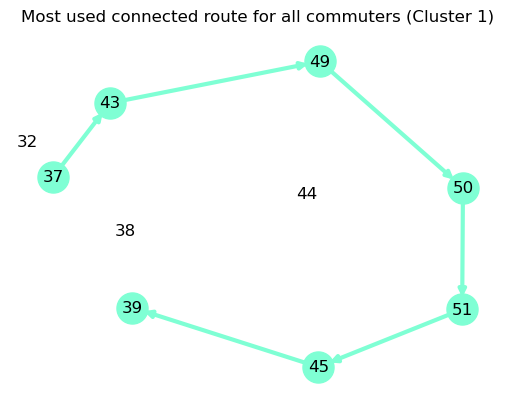

In [51]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

G, route = find_filtered_route('mrtJourneys.csv', "none", cluster1, 4)

# print(route)

draw_graph_with_path(G, route, 'Most used connected route for all commuters (Cluster 1)', pos,'aquamarine')
draw_path(G, route, 'Most used connected route for all commuters (Cluster 1)', pos,'aquamarine')

Popular route used by all commuters for Cluster 2

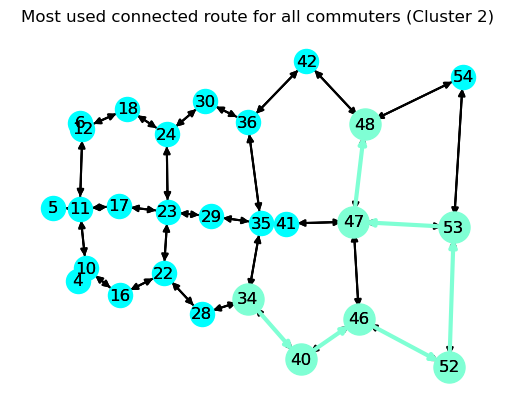

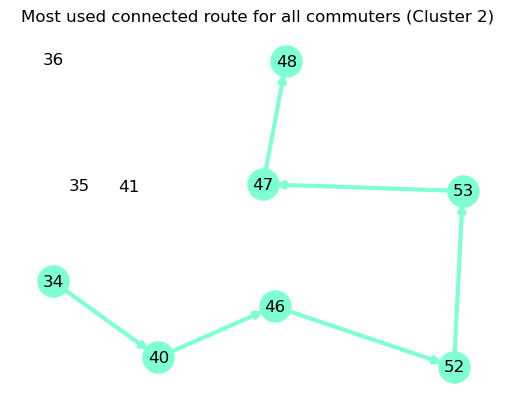

In [52]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


G, route = find_filtered_route('mrtJourneys.csv', "none", cluster2, 1)

draw_graph_with_path(G, route, 'Most used connected route for all commuters (Cluster 2)', pos,'aquamarine')
draw_path(G, route, 'Most used connected route for all commuters (Cluster 2)', pos,'aquamarine')

Popular route used by students

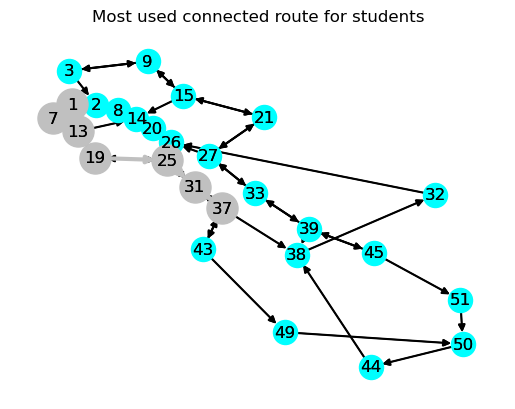

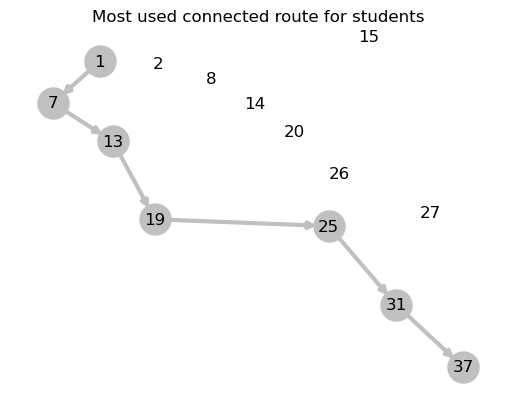

In [83]:
G, route = find_filtered_route('mrtJourneys.csv', "student", cluster1, 1)
draw_graph_with_path(G, route, 'Most used connected route for students', pos,'silver')
draw_path(G, route, 'Most used connected route for students', pos,'silver')


Popular route used by politicians for Cluster 1

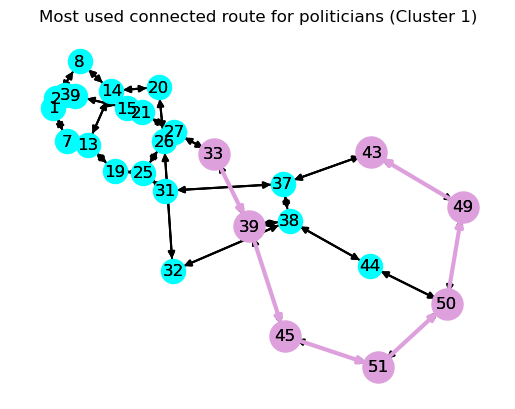

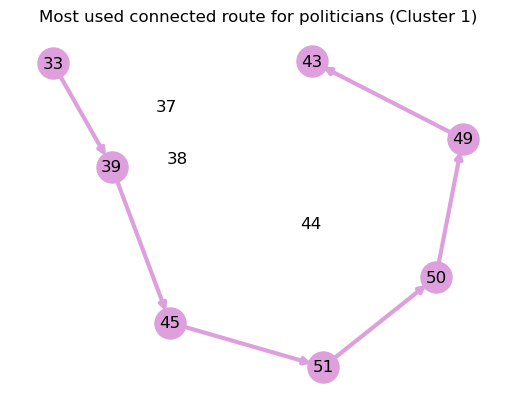

In [54]:

G, route = find_filtered_route('mrtJourneys.csv', "politician", cluster1, 4)

draw_graph_with_path(G, route, 'Most used connected route for politicians (Cluster 1)', pos, '#DDA0DD')
draw_path(G, route, 'Most used connected route for politicians (Cluster 1)', pos,'#DDA0DD')

Popular route used by politicians for Cluster 2

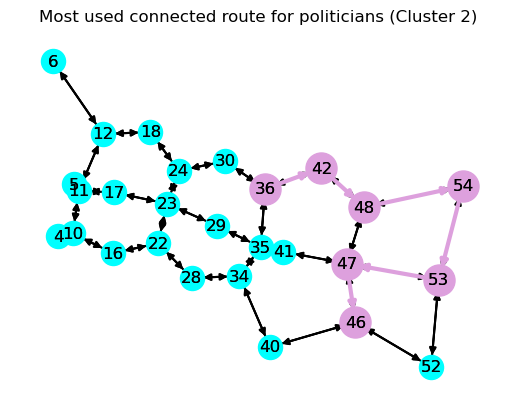

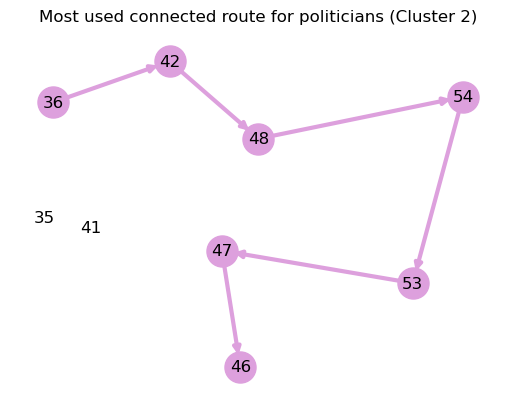

In [55]:
G, route = find_filtered_route('mrtJourneys.csv', "politician", cluster2, 1)

draw_graph_with_path(G, route, 'Most used connected route for politicians (Cluster 2)', pos, '#DDA0DD')
draw_path(G, route, 'Most used connected route for politicians (Cluster 2)', pos,'#DDA0DD')



Popular Route for workers in Cluster 1

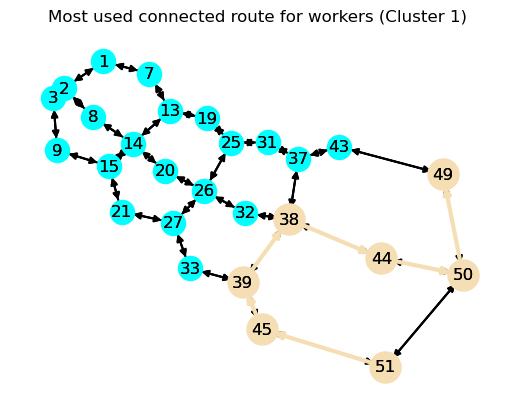

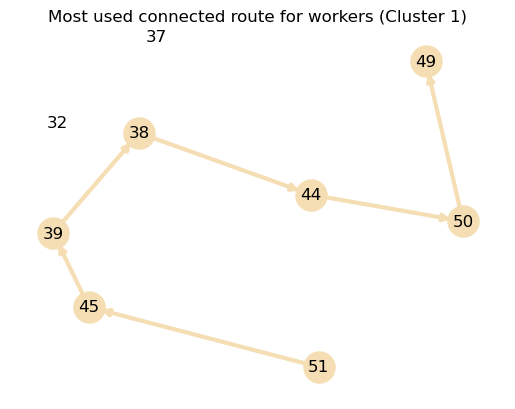

In [56]:
G, route = find_filtered_route('mrtJourneys.csv', "worker", cluster1, 34)

draw_graph_with_path(G, route, 'Most used connected route for workers (Cluster 1)', pos, 'wheat')
draw_path(G, route, 'Most used connected route for workers (Cluster 1)', pos,'wheat')

Popular Routes for Workers in Cluster 2

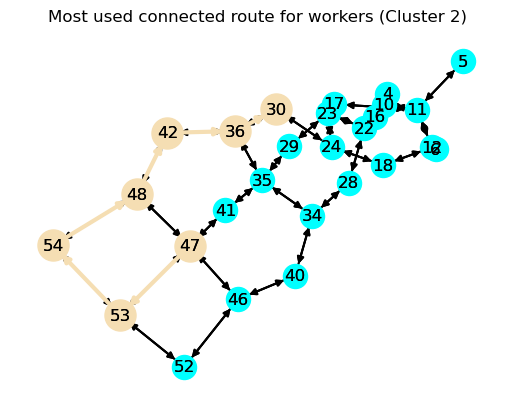

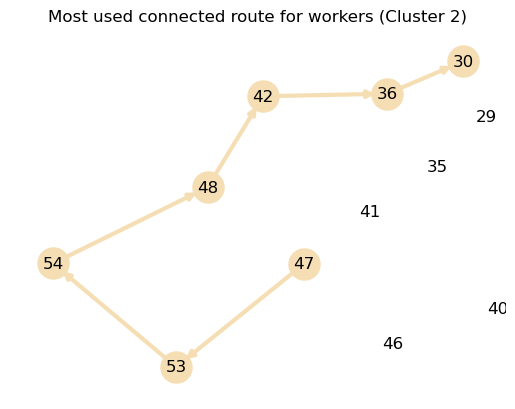

In [57]:
G, route = find_filtered_route('mrtJourneys.csv', "worker", cluster2, 1)

draw_graph_with_path(G, route, 'Most used connected route for workers (Cluster 2)', pos, 'wheat')
draw_path(G, route, 'Most used connected route for workers (Cluster 2)', pos,'wheat')

By finding the most popular routes taken by different occupations in each cluster, we can better enhance the MRT travelling experience by improving train frequency and capacity along these routes. This will help to alleviate congestion and improve the overall travel experience for commuters, especially during peak hours. This will also help to reduce the waiting time for commuters, which is a key factor in determining the overall satisfaction of commuters. We can also better allocate resources to these routes to ensure that they are well maintained and that there are no disruptions along these routes relative to routes that are less popular.

When we anticipate commuter demand along these routes to vary (students will be less likely to travel during the weekends, for example), we can also adjust the train frequency and capacity accordingly to match the anticipated demand and reallocate the extra resources to other routes. 